# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [17]:
# Importing all the necessary libraries
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sw = stopwords.words('english')
lemma = WordNetLemmatizer()

In [18]:
# Function to scrape the British Airways Airline reviews.
def scrape_data(pages):
    reviews = []

    for i in range (1, pages + 1):
        print (f"Scraping page {i}")
        page_size = 100
        base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

        # Create a URL to collect links from paginates data
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

        # Collect the HTML Data from this page
        response = requests.get(url)

        # Parsing the content
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')
        rating_score = parsed_content.find_all("div", {"class": "rating-10"})[1:]
        profile = parsed_content.find_all("div", {"class": "body"})

        for index, passenger in enumerate (profile):
            profile = {}
            rating = rating_score[index].get_text()
            header = passenger.find("h2", {"class": "text_header"}).get_text()
            loc_time = passenger.find("h3", {"class": "text_sub_header"}).get_text()
            review = passenger.find("div", {"class": "text_content"}).get_text()
            table = passenger.find('table', {"class": "review-ratings"})
            if table is not None:
                recommend = table.find_all('td', {"class": "review-value"})[-1].get_text()
            else:
                recommend = "N/A"

            profile.update([('header', header),
                            ('review', review),
                            ('loc_time', loc_time),
                            ('rating', rating),
                            ('recommend', recommend)])
            reviews.append(profile)
        print (f"    ---> {len(reviews)} total reviews")
    return reviews

In [19]:
# Creating the dataset of reviews
reviews_list = scrape_data(35)
df = pd.DataFrame(reviews_list)
df.head()

Scraping page 1
    ---> 100 total reviews
Scraping page 2
    ---> 200 total reviews
Scraping page 3
    ---> 300 total reviews
Scraping page 4
    ---> 400 total reviews
Scraping page 5
    ---> 500 total reviews
Scraping page 6
    ---> 600 total reviews
Scraping page 7
    ---> 700 total reviews
Scraping page 8
    ---> 800 total reviews
Scraping page 9
    ---> 900 total reviews
Scraping page 10
    ---> 1000 total reviews
Scraping page 11
    ---> 1100 total reviews
Scraping page 12
    ---> 1200 total reviews
Scraping page 13
    ---> 1300 total reviews
Scraping page 14
    ---> 1400 total reviews
Scraping page 15
    ---> 1500 total reviews
Scraping page 16
    ---> 1600 total reviews
Scraping page 17
    ---> 1700 total reviews
Scraping page 18
    ---> 1800 total reviews
Scraping page 19
    ---> 1900 total reviews
Scraping page 20
    ---> 2000 total reviews
Scraping page 21
    ---> 2100 total reviews
Scraping page 22
    ---> 2200 total reviews
Scraping page 23
    ---> 23

,header,review,loc_time,rating,recommend
0,"""Excellent service""",✅ Trip Verified | Excellent service both on th...,\n\nIan Sinclair (United Kingdom) 24th January...,\n9/10\n,yes
1,"""Sound dinner service""",✅ Trip Verified | Good lounge at Cape Town. O...,\n\nE Smyth (United Kingdom) 24th January 2023,\n9/10\n,yes
2,"""A really excellent journey""",✅ Trip Verified | A really excellent journey....,\n\n Horton (United Kingdom) 23rd January 2023,\n9/10\n,yes
3,"""flight was one of the worst""",✅ Trip Verified | This flight was one of the ...,\n\nMarian Benedikovic (United Kingdom) 21st J...,\n2/10\n,no
4,"""there is a race to the bottom""",Not Verified | It seems that there is a race t...,\n\nThomas Kowalski (United States) 19th Janua...,\n3/10\n,no


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

---

# Cleaning the data

In [20]:
# Function to clean the rating column
def clean_rating(corpus):
    word = re.sub('\n',' ', corpus)                     # Remove the new line characters
    word = word.split('/')[0]                       # Get the actual rating
    return word


# Function to clean the header column
def clean_header(corpus):
    word = corpus.lower()                            # Converting content to lowercase
    word = re.sub('[^a-zA-Z0-9]',' ', word)          # Removing any special characters
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word


# Function to clean the review column
def clean_review(corpus):
    word = corpus.split('|')                          # Removing the characters before |
    if len(word) > 1:
        word = word[1]
    else:
        word = word[0]
    word = word.lower()                               # Converting to lowercase
    word = re.sub('[^a-zA-Z0-9]',' ', word)           # Removing any special characters
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word


# Function to clean the location and time column
def clean_loc_time(corpus):
    full = corpus.split('(')

    if len(full) > 1:
        full = full [1]
    else:
        full = full[0]

    full = full.split(')')                              # Getting the location and date
    return full


# Applying all the clean functions together for their respective columns
def clean_scraped_data(df):
    df['header'] = df['header'].apply(clean_header)
    df['rating'] = df['rating'].apply(clean_rating)
    df['review'] = df['review'].apply(clean_review)
    split = pd.DataFrame(df['loc_time'].apply(clean_loc_time).tolist(), columns=['country', 'date'])
    df = pd.concat([df, split], axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(['loc_time'], axis=1, inplace=True)
    return df



In [21]:
# Creating the dataset of reviews
reviews_list = scrape_data(35)
df = pd.DataFrame(reviews_list)
df = clean_scraped_data(df)
df.head()

Scraping page 1
    ---> 100 total reviews
Scraping page 2
    ---> 200 total reviews
Scraping page 3
    ---> 300 total reviews
Scraping page 4
    ---> 400 total reviews
Scraping page 5
    ---> 500 total reviews
Scraping page 6
    ---> 600 total reviews
Scraping page 7
    ---> 700 total reviews
Scraping page 8
    ---> 800 total reviews
Scraping page 9
    ---> 900 total reviews
Scraping page 10
    ---> 1000 total reviews
Scraping page 11
    ---> 1100 total reviews
Scraping page 12
    ---> 1200 total reviews
Scraping page 13
    ---> 1300 total reviews
Scraping page 14
    ---> 1400 total reviews
Scraping page 15
    ---> 1500 total reviews
Scraping page 16
    ---> 1600 total reviews
Scraping page 17
    ---> 1700 total reviews
Scraping page 18
    ---> 1800 total reviews
Scraping page 19
    ---> 1900 total reviews
Scraping page 20
    ---> 2000 total reviews
Scraping page 21
    ---> 2100 total reviews
Scraping page 22
    ---> 2200 total reviews
Scraping page 23
    ---> 23

,header,review,rating,recommend,country,date
0,excellent service,excellent service ground board first class pro...,9,yes,United Kingdom,2023-01-24
1,sound dinner service,good lounge cape town time departure drink hig...,9,yes,United Kingdom,2023-01-24
2,really excellent journey,really excellent journey lounge overcrowded la...,9,yes,United Kingdom,2023-01-23
3,flight one worst,flight one worst ever life wanted pamper bough...,2,no,United Kingdom,2023-01-21
4,race bottom,seems race bottom amongst airline even check b...,3,no,United States,2023-01-19


---
### Checking for Missing Values

In [22]:
df.isna().sum()

header       0
review       0
rating       0
recommend    0
country      0
date         2
dtype: int64

In [23]:
df.to_csv("data/BA_cleaned_reviews.csv")

---
# Data Analysis

In [30]:
# Converting any numerical features to int
df = df[df['rating']!='\r                         na\r                     ']
df ['rating'] = df['rating'].astype('Int64')

In [31]:
df.dtypes

header               object
review               object
rating                Int64
recommend            object
country              object
date         datetime64[ns]
dtype: object

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3463
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   header     3459 non-null   object        
 1   review     3459 non-null   object        
 2   rating     3459 non-null   Int64         
 3   recommend  3459 non-null   object        
 4   country    3459 non-null   object        
 5   date       3457 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(4)
memory usage: 192.5+ KB


The primary purpose of this project is to determine what is not going well with the customers and change it. Indicating that we need to figure out the overall rating and

AxesSubplot(0.125,0.11;0.775x0.77)


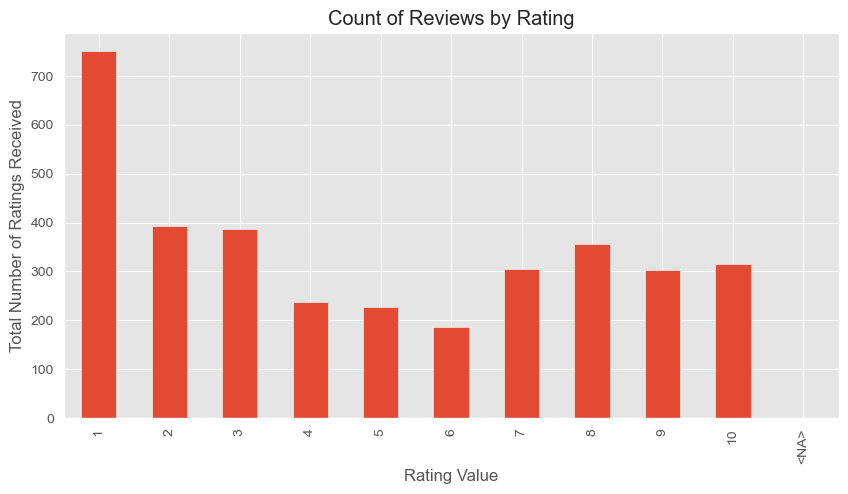

In [38]:
count_rating_reviews = df['rating'].value_counts(dropna=False).sort_index().plot(kind='bar', figsize=(10,5))
count_rating_reviews.set (title = "Count of Reviews by Rating",
                          xlabel = "Rating Value",
                          ylabel = "Total Number of Ratings Received")
print(count_rating_reviews)
plt.show()

### Creating a Pie Chart showing the total number of recommendations

Text(0.5, 1.0, 'Pie Chart of the Total Recommendations by Category')

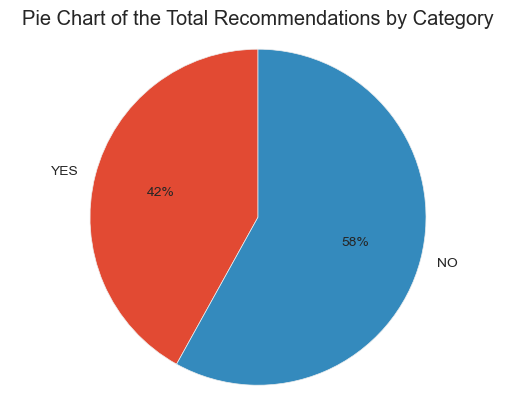

In [39]:
fig = plt.figure()
recommend_yes = df[df['recommend'] == 'yes']
recommend_no = df[df['recommend'] == 'no']

x = [len(recommend_yes), len(recommend_no)]
plt.pie(x, labels = ['YES', 'NO'], startangle=90, autopct='%.f%%')
plt.axis('equal')
plt.title('Pie Chart of the Total Recommendations by Category')